# Построение моделей временных рядов

In [1]:
## импорт заивисимостей

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import HTML

## Исходные данные

In [2]:
data = pd.read_csv("data_series.csv")
HTML(data.T.to_html(header = False))

t,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0
y,27.3,41.8,42.8,56.2,72.5,56.0,70.0,74.9,103.3,111.3,125.2,189.3,169.1,193.5,207.4,221.2,267.2,264.0,273.8,321.0,317.4,342.0,350.6,368.5,397.0,382.9,400.6,409.4,426.0,402.0,398.7,418.1,426.6,435.1,439.8


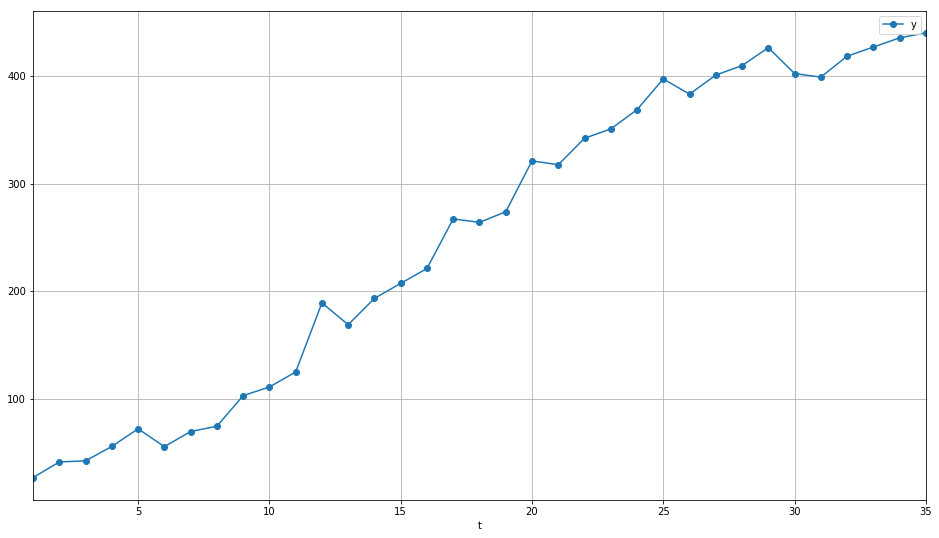

In [3]:
data.plot(x = 't', y = 'y', figsize=(16, 9), grid = True, marker='o')

## Вспомогательные функции и переменные

### Количество шагов ($\tau$), на которые будет производится 
Для всех моделей, прогноз будет производится на 4 шага вперед

In [4]:
TAU = 4

### Функция определения коэффициентов a,b по МНК

In [5]:
def segment_slope(d, size = 5):
    X, Y = d.iloc[:size, 0], d.iloc[:size, 1]
    X_mean, Y_mean = np.mean(X), np.mean(Y)
    n,d = 0,0
    for i in range(len(X)):
        n += (X[i] - X_mean)*(Y[i] - Y_mean)
        d += (X[i] - X_mean)**2
    b = n / d
    a = Y_mean - b*X_mean
    return a,b

In [6]:
linear = lambda a,b,t: a+b*t

In [7]:
SF_start_values = lambda y, yr: [0.5*(y[i]-yr[i]+y[i+4]-yr[i+4]) for i in range(4)]

### Критерий Дарбина-Уотсона

### R/S критерий

In [8]:
rs_crit = lambda e: round((max(e)-min(e))/np.std(e),2)

### Критерий Стьюдента

In [39]:
###

## Модель Брауна

### Определение параметра $\alpha$

In [9]:
alpha = 0.3

In [10]:
beta = 1 - alpha
a0,a1 = segment_slope(data)
print(a0, a1)

16.679999999999996 10.48


In [11]:
y = data.iloc[:, 1]
yth = []
e = []
yth.append(sum([a0,a1]))
e.append(y[0]-yth[0])
e_appr = []
print(yth, e)
for i in range(1,len(y)):
    a0 = a0 + a1 + (1- beta**2)*e[i-1]
    a1 = a1 + (1 - beta)**2*e[i-1]
    yi = sum([a0,a1])
    yth.append(yi)
    e.append(y[i]-yi)
    
for i in range(0,len(y)):
    e_appr.append(abs(e[i])/y[i])

[27.159999999999997] [0.14000000000000412]


In [12]:
brown_model = data.copy()
brown_model.insert(2, 'yth', yth)
brown_model.insert(3, 'e', e)
brown_model.insert(4, 'e_appr', e_appr)
HTML(brown_model.to_html(index = False))

t,y,yth,e,e_appr
1,27.3,27.160000,0.140000,0.005128
2,41.8,37.724000,4.076000,0.097512
3,42.8,50.662200,-7.862200,0.183696
4,56.2,56.804320,-0.604320,0.010753
5,72.5,66.593570,5.906430,0.081468
6,56.0,80.234881,-24.234881,0.432766
7,70.0,76.322984,-6.322984,0.090328
8,74.9,80.977086,-6.077086,0.081136
9,103.3,85.209659,18.090341,0.175124
10,111.3,103.395750,7.904250,0.071018


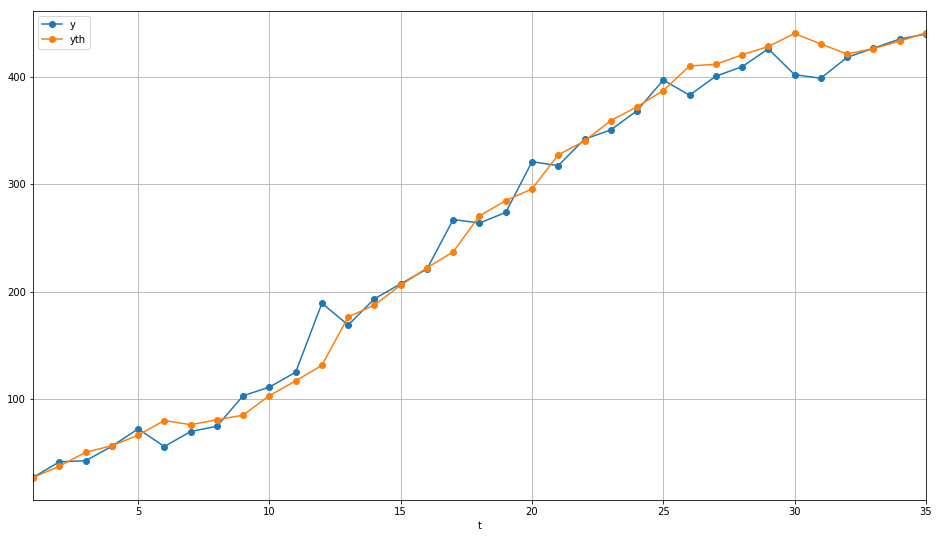

In [13]:
plot = brown_model.plot(x = 't', y = ['y','yth'], figsize=(16, 9), grid = True, marker='o')

## Адекватность и точность модели

### Срденяя ошибка аппроксимации

In [14]:
err = np.mean(e_appr)*100
print('{}%'.format(round(err,2)))

6.74%


### R/S критерий

In [15]:
value = rs_crit(e)
print(value)

5.66


### t-критерий Стьюдента

In [40]:
value = student(y,yth)
print(value)

-0.005904122984495275


## Прогноз по модели Брауна на 4 шага вперед

In [16]:
p = []
for i in range(1,TAU+1):
    yi = a0+a1*i
    p.append(yi)
print(p)

[440.95705421265683, 447.7980206088457, 454.63898700503455, 461.47995340122344]


In [17]:
for index, item in enumerate(p):
    brown_model = brown_model.append({'t': 1+index+len(data['t']), 'pred': item}, ignore_index = True) 
brown_model.loc[len(data['t'])-1, 'pred'] = brown_model.loc[len(data['t'])-1,'yth']
HTML(brown_model.to_html(index=False))

t,y,yth,e,e_appr,pred
1.0,27.3,27.160000,0.140000,0.005128,NaN
2.0,41.8,37.724000,4.076000,0.097512,NaN
3.0,42.8,50.662200,-7.862200,0.183696,NaN
4.0,56.2,56.804320,-0.604320,0.010753,NaN
5.0,72.5,66.593570,5.906430,0.081468,NaN
6.0,56.0,80.234881,-24.234881,0.432766,NaN
7.0,70.0,76.322984,-6.322984,0.090328,NaN
8.0,74.9,80.977086,-6.077086,0.081136,NaN
9.0,103.3,85.209659,18.090341,0.175124,NaN
10.0,111.3,103.395750,7.904250,0.071018,NaN


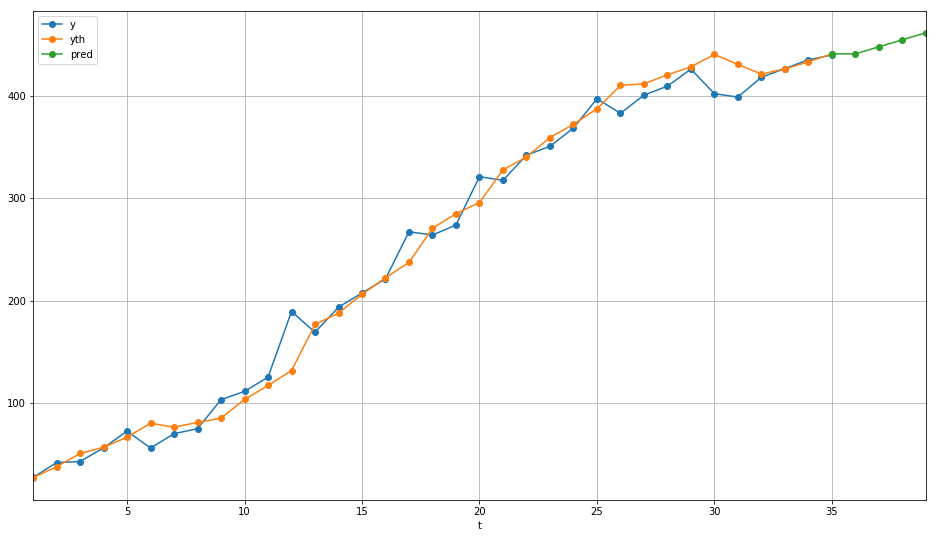

In [18]:
brown_model.plot(x = 't', y = ['y','yth', 'pred'], figsize=(16, 9), grid = True, marker='o')

## Модель Хольта-Уинтерса

### Определение параметров $\alpha, \beta$

In [19]:
a, b = 0.4, 0.01
g, d = 1 - alpha, 1 - beta 

In [20]:
y = data.iloc[:, 1]
Ft = [y[0]]
St = [y[1]-y[0]]
yth = [y[0]]
e = [y[0]-yth[0]]
for i in range(1,len(y)):
    Fi = alpha*y[i]+g*(Ft[i-1]+St[i-1])
    Ft.append(round(Fi,2))
    Si = beta*(Ft[i]-Ft[i-1])+d*St[i-1]
    St.append(round(Si,2))
    yi = Ft[i]+St[i]
    yth.append(yi)
    e.append(y[i]-yi)

In [21]:
holt_winters_model = data.copy()
holt_winters_model.insert(2, 'Ft', Ft)
holt_winters_model.insert(3, 'St', St)
holt_winters_model.insert(4, 'yth', yth)
holt_winters_model.insert(5, 'e', e)
HTML(holt_winters_model.to_html(index = False))

t,y,Ft,St,yth,e
1,27.3,27.30,14.50,27.30,0.00
2,41.8,41.80,14.50,56.30,-14.50
3,42.8,52.25,11.67,63.92,-21.12
4,56.2,61.60,10.05,71.65,-15.45
5,72.5,71.90,10.23,82.13,-9.63
6,56.0,74.29,4.74,79.03,-23.03
7,70.0,76.32,2.84,79.16,-9.16
8,74.9,77.88,1.94,79.82,-4.92
9,103.3,86.86,6.87,93.73,9.57
10,111.3,99.00,10.56,109.56,1.74


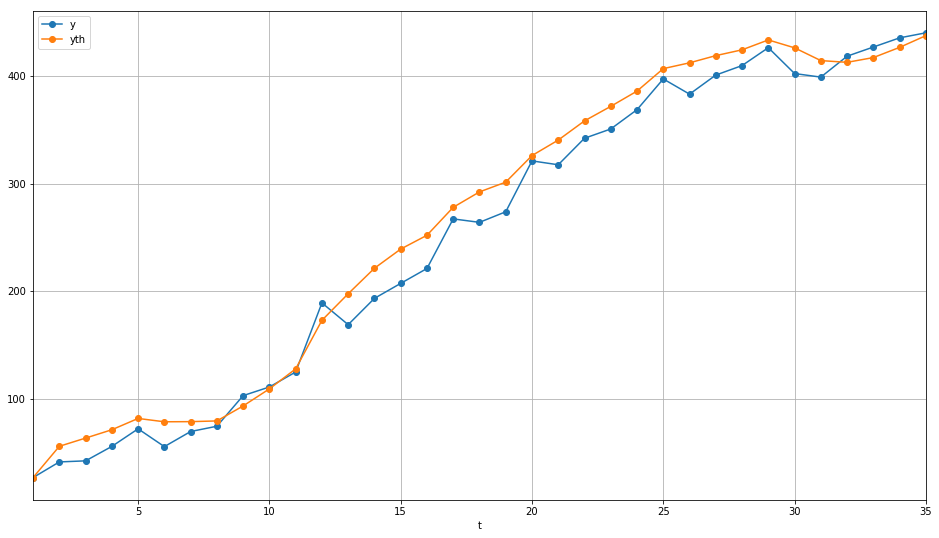

In [22]:
holt_winters_model.plot(x = 't', y = ['y','yth'], figsize=(16, 9), grid = True, marker='o')

## Прогноз по модели Хольта-Уинтерса на 4 шага вперед

In [23]:
p = []
l = len(yth)
for i in range(1,TAU+1):
    yi = Fi+((l+i)-l)*Si
    p.append(yi)
print(p)

[437.168, 443.99299999999994, 450.8179999999999, 457.6429999999999]


In [24]:
for index, item in enumerate(p):
    holt_winters_model = holt_winters_model.append({'t': 1+index+len(data['t']), 'pred': item}, ignore_index = True) 
holt_winters_model.loc[len(data['t'])-1, 'pred'] = holt_winters_model.loc[len(data['t'])-1,'yth']
HTML(holt_winters_model.to_html(index=False))

t,y,Ft,St,yth,e,pred
1.0,27.3,27.30,14.50,27.30,0.00,NaN
2.0,41.8,41.80,14.50,56.30,-14.50,NaN
3.0,42.8,52.25,11.67,63.92,-21.12,NaN
4.0,56.2,61.60,10.05,71.65,-15.45,NaN
5.0,72.5,71.90,10.23,82.13,-9.63,NaN
6.0,56.0,74.29,4.74,79.03,-23.03,NaN
7.0,70.0,76.32,2.84,79.16,-9.16,NaN
8.0,74.9,77.88,1.94,79.82,-4.92,NaN
9.0,103.3,86.86,6.87,93.73,9.57,NaN
10.0,111.3,99.00,10.56,109.56,1.74,NaN


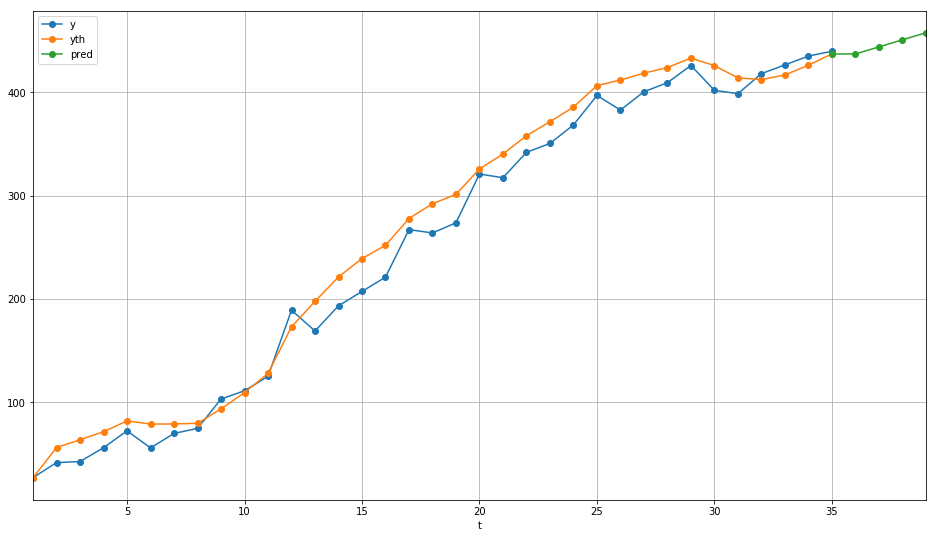

In [25]:
holt_winters_model.plot(x = 't', y = ['y','yth', 'pred'], figsize=(16, 9), grid = True, marker='o')

## Модель Телла-Вейджа

### Определение параметров $\lambda_1,\lambda_2,\lambda_3$

In [26]:
l1, l2, l3 = 0.1,0.2,0.1

In [27]:
a0,a1 = segment_slope(data)
print(a0, a1)
y_r = [linear(a0,a1,i) for i in range(1,9)] 
print(y_r)
y = data.iloc[:, 1]
w = SF_start_values(y,y_r)
print(w)

16.679999999999996 10.48
[27.159999999999997, 37.64, 48.12, 58.599999999999994, 69.08, 79.56, 90.03999999999999, 100.52]
[1.7800000000000011, -9.700000000000003, -12.679999999999993, -14.009999999999991]


In [28]:
yth = []
e = []
for i in range(0,len(y)):
    yi = a0+a1+w[i]
    yth.append(yi)
    e.append(y[i]-yi)
    temp = a0
    a0 = l1*(y[i]-w[i])+(1-l1)*(a0+a1)
    a1 = l2*(a0-temp)+(1-l2)*a1
    w.append(l3*(y[i]-a0)+(1-l3)*w[i])

In [29]:
tella_weige_model = data.copy()
tella_weige_model.insert(2, 'yth', yth)
tella_weige_model.insert(3, 'w', w[4:])
tella_weige_model.insert(4, 'e', e)
HTML(tella_weige_model.to_html(index = False))

t,y,yth,w,e
1,27.3,28.940000,1.632400,-1.640000
2,41.8,27.743200,-8.434888,14.056800
3,42.8,36.897216,-12.148749,5.902784
4,56.2,47.003886,-13.182350,9.196114
5,72.5,74.596211,1.443741,-2.096211
6,56.0,75.307692,-10.172580,-19.307692
7,70.0,80.265297,-13.072626,-10.265297
8,74.9,88.602097,-14.415538,-13.702097
9,103.3,111.980866,0.662463,-8.680866
10,111.3,109.445729,-10.005696,1.854271


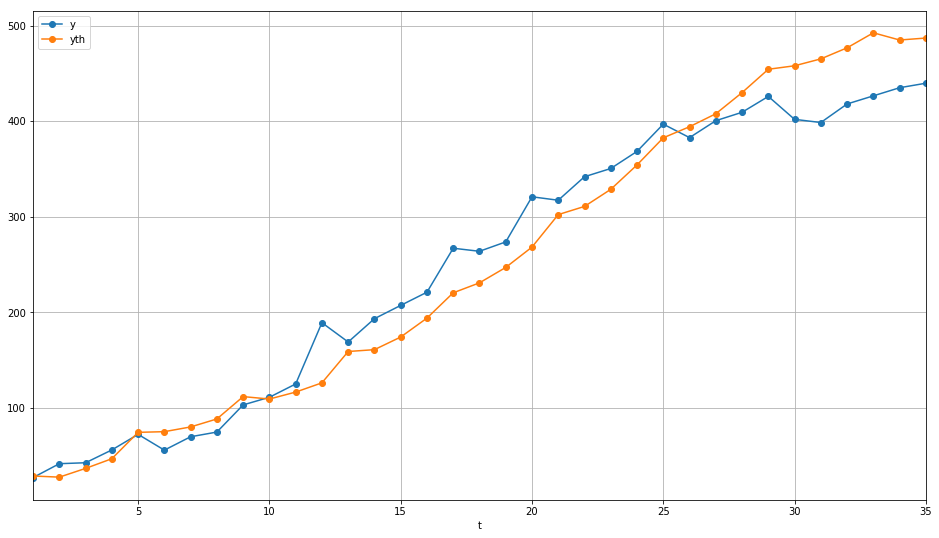

In [30]:
tella_weige_model.plot(x = 't', y = ['y','yth'], figsize=(16, 9), grid = True, marker='o')

## Прогноз по модели Телла-Вейджа на 4 шага вперед

In [31]:
p = []
l = len(yth)
for i in range(1,TAU+1):
    yi = (a0+a1*TAU)+w[i+len(yth)-1]
    p.append(yi)
print(p)

[527.8244523407204, 535.1661796747399, 523.3831937585309, 519.4028085784531]


In [32]:
for index, item in enumerate(p):
    tella_weige_model = tella_weige_model.append({'t': 1+index+len(data['t']), 'pred': item}, ignore_index = True) 
tella_weige_model.loc[len(data['t'])-1, 'pred'] = tella_weige_model.loc[len(data['t'])-1,'yth']
HTML(tella_weige_model.to_html(index=False))

t,y,yth,w,e,pred
1.0,27.3,28.940000,1.632400,-1.640000,NaN
2.0,41.8,27.743200,-8.434888,14.056800,NaN
3.0,42.8,36.897216,-12.148749,5.902784,NaN
4.0,56.2,47.003886,-13.182350,9.196114,NaN
5.0,72.5,74.596211,1.443741,-2.096211,NaN
6.0,56.0,75.307692,-10.172580,-19.307692,NaN
7.0,70.0,80.265297,-13.072626,-10.265297,NaN
8.0,74.9,88.602097,-14.415538,-13.702097,NaN
9.0,103.3,111.980866,0.662463,-8.680866,NaN
10.0,111.3,109.445729,-10.005696,1.854271,NaN


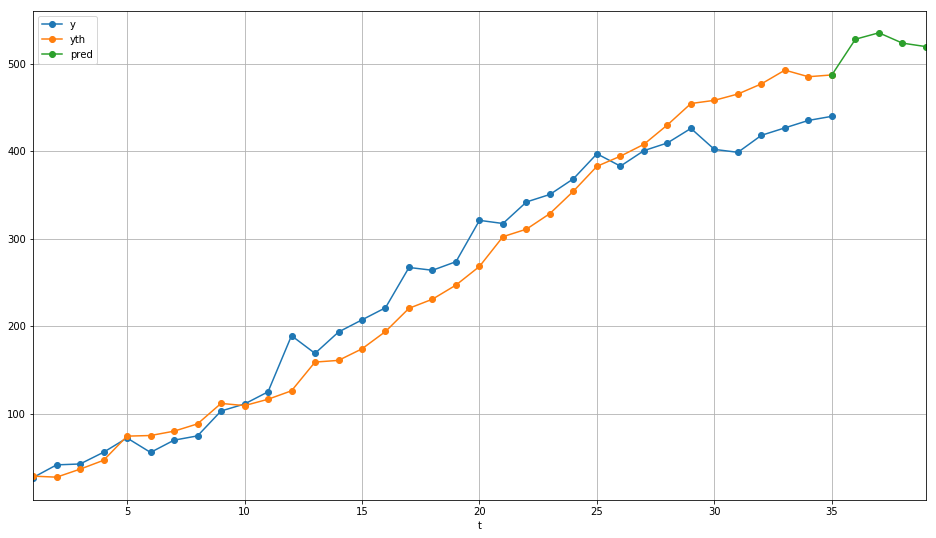

In [33]:
tella_weige_model.plot(x = 't', y = ['y','yth', 'pred'], figsize=(16, 9), grid = True, marker='o')